# GNN Benchmarking for Stock Return Prediction
**2025-10-06**

This notebook implements an end-to-end thesis pipeline:
1) Data download (S&P 500-ish demo list) via `yfinance`
2) Feature engineering & labels (next-day up/down)
3) Baselines: Logistic Regression & XGBoost
4) Graph construction from rolling correlations; PyTorch Geometric dataset
5) GNN (GCN) training & evaluation
6) Robustness: shuffled returns and random edges tests
7) Regime analysis (calm vs crisis)




In [ ]:
# %pip install -q yfinance pandas numpy matplotlib scikit-learn xgboost tqdm
# %pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cu121
# %pip install -q torch-geometric torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.3.0+cu121.html


# Imports & global config

In [ ]:
import warnings, math, random, gc
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_geometric.nn import GCNConv

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

START_DATE = "2015-01-01"
END_DATE   = "2024-12-31"

# Graph parameters
ROLL_WINDOW = 60      # days for rolling correlation
CORR_TH     = 0.4     # abs(corr) threshold to create an edge
MIN_HISTORY = 80      # skip first ~80 days to stabilize features

# Splits (chronological)
TRAIN_END = "2019-12-31"
VAL_END   = "2020-12-31"

# For Precision@K: either fraction of universe per day, or absolute number
TOP_K_FRAC = 0.10   # 10% of the cross-section per day
TOP_K_ABS  = None   # e.g. 25 to force top-25; if set, beats TOP_K_FRAC


# stock universe

In [ ]:
# 30 large caps across sectors keeps graphs meaningful but fast.
TICKERS = [
    # Tech
    "AAPL","MSFT","GOOGL","NVDA","META",
    # Finance
    "JPM","BAC","GS","V","MA",
    # Consumer
    "WMT","COST","DIS","KO","PEP",
    # Healthcare
    "PFE","UNH","JNJ",
    # Energy
    "XOM","CVX",
    # Industrials / Others
    "CAT","HD","MCD","NKE","ORCL","IBM","TXN","INTC","AMZN"
]


# Download prices and basic returns

In [ ]:

# ==== Data download ====

data = yf.download(TICKERS, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)
prices = data['Close'].dropna(how='all')
prices = prices.dropna(axis=1, how='any')  # remove tickers with missing history
print("Prices shape:", prices.shape)



Prices shape: (2515, 29)


# Feature engineering + labels (safe & simple)

In [ ]:
def compute_returns(prices: pd.DataFrame, lag=1):
    return prices.pct_change(lag)

def rolling_volatility(returns: pd.DataFrame, window=20):
    return returns.rolling(window).std()

def rolling_beta(stock_returns: pd.DataFrame, market_returns: pd.Series, window=60):
    cov = stock_returns.rolling(window).cov(market_returns)
    var = market_returns.rolling(window).var()
    beta = cov.div(var, axis=0)
    return beta

# returns & stats
rets_1d  = compute_returns(prices, 1)
rets_5d  = compute_returns(prices, 5)
rets_21d = compute_returns(prices, 21)
vol_20d  = rolling_volatility(rets_1d, 20)

spy = yf.download("^GSPC", start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)['Close']
spy_ret = spy.pct_change(1)
beta_60d = rolling_beta(rets_1d, spy_ret, 60)

# Label = next-day direction
label_df = (rets_1d.shift(-1) > 0).astype(int)

def stack_features(feat_df, name):
    s = feat_df.stack().rename(name).to_frame()
    s.index.set_names(['date','ticker'], inplace=True)
    return s

# Build features safely; no name collisions with torch.nn.functional
features_list = []
for name, df in {
    "ret_1d": rets_1d,
    "ret_5d": rets_5d,
    "ret_21d": rets_21d,
    "vol_20d": vol_20d,
    "beta_60d": beta_60d
}.items():
    f = stack_features(df, name)
    if len(f) > 0:
        features_list.append(f)
        print(f"{name} shape:", f.shape)

X = pd.concat(features_list, axis=1)
X = X.dropna(how="all").fillna(0)

y = stack_features(label_df, 'label').reindex(X.index).dropna()
X = X.loc[y.index]

# Cross-sectional z-score per day (focus on relative info)
X_z = X.groupby(level='date').transform(lambda col: (col - col.mean())/(col.std(ddof=0) + 1e-9))

# Stabilize: drop early days without enough history
valid_dates = prices.index[MIN_HISTORY:]
X_z = X_z.loc[X_z.index.get_level_values('date').isin(valid_dates)]
y   = y.loc[X_z.index]

print("Final feature/label shapes:", X_z.shape, y.shape)


ret_1d shape: (72906, 1)
ret_5d shape: (72790, 1)
ret_21d shape: (72326, 1)
vol_20d shape: (72355, 1)
Final feature/label shapes: (70615, 4) (70615, 1)


# Split by time (no leakage)

In [ ]:
dates = X_z.index.get_level_values('date')
train_mask = dates <= pd.to_datetime(TRAIN_END)
val_mask   = (dates > pd.to_datetime(TRAIN_END)) & (dates <= pd.to_datetime(VAL_END))
test_mask  = dates > pd.to_datetime(VAL_END)

X_train, y_train = X_z[train_mask], y[train_mask]
X_val,   y_val   = X_z[val_mask],   y[val_mask]
X_test,  y_test  = X_z[test_mask],  y[test_mask]

len(X_train), len(X_val), len(X_test)


(34162, 7337, 29116)

# Metrics & evaluation helpers (robust, no NaNs)

In [ ]:
def _resolve_k(n_per_day: int) -> int:
    if TOP_K_ABS is not None:
        k = TOP_K_ABS
    elif TOP_K_FRAC is not None:
        k = max(1, int(round(TOP_K_FRAC * n_per_day)))
    else:
        k = max(1, int(round(0.1 * n_per_day)))
    return min(k, max(1, n_per_day))

def precision_at_k(scores: np.ndarray, labels: np.ndarray, k: int) -> float:
    mask = ~np.isnan(scores) & ~np.isnan(labels)
    s = scores[mask].astype(float); y = labels[mask].astype(int)
    n = len(s)
    if n == 0: return np.nan
    k = min(max(1, k), n)
    idx = np.argsort(-s, kind="mergesort")[:k]
    return float(np.mean(y[idx])) if k > 0 else np.nan

def daily_metric_aggregate(df_scores: pd.DataFrame) -> pd.Series:
    rows = []
    for d, sub in df_scores.groupby('date'):
        y = sub['label'].to_numpy()
        s = sub['score'].to_numpy()
        y_hat = (s >= 0.5).astype(int)

        # metrics with safe guards
        acc = accuracy_score(y, y_hat) if len(np.unique(y))>=1 else np.nan
        auc = roc_auc_score(y, s) if len(np.unique(y))>1 else np.nan
        f1  = f1_score(y, y_hat)  if len(np.unique(y))>1 else np.nan

        k = _resolve_k(len(sub))
        p_at_k = precision_at_k(s, y, k=k)
        rows.append((d, acc, auc, f1, p_at_k))

    out = pd.DataFrame(rows, columns=['date','acc','auc','f1','p_at_k']).set_index('date')
    return out.mean(skipna=True)

def evaluate_tabular_model(model, X_df, y_df):
    """
    Evaluate a sklearn model (LogReg, XGBoost) on time-indexed data.
    """
    dates = X_df.index.get_level_values('date')
    scores = model.predict_proba(X_df.values)[:, 1]
    tmp = pd.DataFrame({
        'date': dates.values,
        'score': scores,
        'label': y_df.astype(float)
    })
    return daily_metric_aggregate(tmp)


# Baselines: Logistic Regression & XGBoost

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=2000, solver='saga', penalty='l2', n_jobs=-1)
lr.fit(X_train.values, y_train.values.ravel())
lr_val  = evaluate_tabular_model(lr, X_val,  y_val.values.ravel())
lr_test = evaluate_tabular_model(lr, X_test, y_test.values.ravel())

# XGBoost
xgb = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.8, reg_lambda=1.0,
    tree_method='hist', random_state=SEED
)
xgb.fit(X_train.values, y_train.values.ravel(),
        eval_set=[(X_val.values, y_val.values.ravel())],
        verbose=False)
xgb_val  = evaluate_tabular_model(xgb, X_val,  y_val.values.ravel())
xgb_test = evaluate_tabular_model(xgb, X_test, y_test.values.ravel())

print("LogReg TEST:\n", lr_test)
print("XGBoost TEST:\n", xgb_test)


LogReg TEST:
 acc       0.521122
auc       0.501120
f1        0.652757
p_at_k    0.501660
dtype: float64
XGBoost TEST:
 acc       0.517654
auc       0.501034
f1        0.597918
p_at_k    0.521912
dtype: float64


# Build daily graphs (rolling correlation → edges)

In [ ]:
# Fix the node order for all snapshots
tickers_used = sorted(prices.columns.intersection(pd.Index(X_z.index.get_level_values('ticker').unique())))
ticker_to_idx = {t:i for i,t in enumerate(tickers_used)}

returns_1d = prices.pct_change(1)

def build_edge_index_for_day(day, corr_th=CORR_TH):
    if day not in returns_1d.index: return None
    end_loc = returns_1d.index.get_loc(day)
    if end_loc < ROLL_WINDOW: return None

    window = returns_1d.iloc[end_loc-ROLL_WINDOW+1:end_loc+1][tickers_used]
    corr = window.corr().fillna(0.0)
    edges = []
    for i in range(len(tickers_used)):
        for j in range(i+1, len(tickers_used)):
            rho = corr.iat[i,j]
            if abs(rho) >= corr_th:
                edges.append([i,j]); edges.append([j,i])
    if not edges: return None
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index

def build_day_tensor(day, X_day, y_day):
    # features/labels for this day, aligned to tickers_used
    x = torch.tensor(X_day.loc[(day,)].reindex(tickers_used).values, dtype=torch.float32)
    y = torch.tensor(y_day.loc[(day,)].reindex(tickers_used).values.astype(int), dtype=torch.long).view(-1)
    edge_index = build_edge_index_for_day(day)
    if edge_index is None: return None
    return Data(x=x, edge_index=edge_index, y=y)

# Build snapshot lists
all_days = sorted(X_z.index.get_level_values('date').unique())
train_days = [d for d in all_days if d <= pd.to_datetime(TRAIN_END)]
val_days   = [d for d in all_days if pd.to_datetime(TRAIN_END) < d <= pd.to_datetime(VAL_END)]
test_days  = [d for d in all_days if d > pd.to_datetime(VAL_END)]

pyg_train, pyg_val, pyg_test = [], [], []
print("Building PyG snapshots...")
for d in tqdm(train_days):
    g = build_day_tensor(d, X_z, y);
    pyg_train.append(g) if g is not None else None
for d in tqdm(val_days):
    g = build_day_tensor(d, X_z, y);
    pyg_val.append(g) if g is not None else None
for d in tqdm(test_days):
    g = build_day_tensor(d, X_z, y);
    pyg_test.append(g) if g is not None else None

len(pyg_train), len(pyg_val), len(pyg_test)


Building PyG snapshots...


100%|██████████| 1004/1004 [00:09<00:00, 104.03it/s]


(1178, 253, 1004)

# Define GCN model + training loop (with validation AUC)

In [ ]:
class GCNNet(nn.Module):
    def __init__(self, in_dim, hid=64, out_dim=2):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid)
        self.conv2 = GCNConv(hid, out_dim)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def loader_from_list(graph_list, batch_size=1, shuffle=False):
    return PyGDataLoader(graph_list, batch_size=batch_size, shuffle=shuffle)

def train_one_epoch(model, optimizer, loader):
    model.train()
    total_loss = 0.0
    for data in loader:
        data = data.to(DEVICE)
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss.item())
    return total_loss / max(1, len(loader))

@torch.no_grad()
def eval_model_collect(model, loader):
    model.eval()
    # returns list of (probs, labels) per snapshot
    batches = []
    for data in loader:
        data = data.to(DEVICE)
        logits = model(data)
        probs = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
        labels = data.y.detach().cpu().numpy()
        batches.append((probs, labels))
    return batches

in_dim = X_z.shape[1]
model = GCNNet(in_dim).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

train_loader = loader_from_list(pyg_train, batch_size=1, shuffle=True)
val_loader   = loader_from_list(pyg_val,   batch_size=1, shuffle=False)
test_loader  = loader_from_list(pyg_test,  batch_size=1, shuffle=False)

best_val_auc = -np.inf
best_state = None
EPOCHS = 10  # you can increase to 30 if you want

for epoch in range(1, EPOCHS+1):
    tr_loss = train_one_epoch(model, opt, train_loader)

    # collect val predictions and map to dates
    val_batches = eval_model_collect(model, val_loader)
    val_rows = []
    for (probs, labels), d in zip(val_batches, [g for g in val_days if g in [x for x in val_days]]):
        for p, l in zip(probs, labels):
            val_rows.append([pd.to_datetime(d), float(p), float(l)])
    val_df = pd.DataFrame(val_rows, columns=['date','score','label'])
    val_stats = daily_metric_aggregate(val_df)
    val_auc = 0.5 if np.isnan(val_stats['auc']) else float(val_stats['auc'])

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}

    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_auc={val_auc:.4f}")

if best_state is not None:
    model.load_state_dict({k: v.to(DEVICE) for k,v in best_state.items()})


Epoch 01 | train_loss=0.6952 | val_auc=0.5234
Epoch 02 | train_loss=0.6931 | val_auc=0.5105
Epoch 03 | train_loss=0.6930 | val_auc=0.5187
Epoch 04 | train_loss=0.6919 | val_auc=0.5239
Epoch 05 | train_loss=0.6923 | val_auc=0.5186
Epoch 06 | train_loss=0.6917 | val_auc=0.5130
Epoch 07 | train_loss=0.6917 | val_auc=0.5186
Epoch 08 | train_loss=0.6916 | val_auc=0.5206
Epoch 09 | train_loss=0.6916 | val_auc=0.5187
Epoch 10 | train_loss=0.6913 | val_auc=0.5196


# Test evaluation (clean daily aggregation)

In [ ]:
@torch.no_grad()
def eval_with_dates(model, graph_list, dates_list):
    model.eval()
    rows = []
    for g, d in zip(graph_list, dates_list):
        g = g.to(DEVICE)
        logits = model(g)
        probs = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
        labels = g.y.detach().cpu().numpy()
        for p, l in zip(probs, labels):
            rows.append([pd.to_datetime(d), float(p), float(l)])
    return pd.DataFrame(rows, columns=['date','score','label'])

test_dates_available = [d for d,g in zip(test_days, pyg_test) if g is not None]
test_graphs_available = [g for g in pyg_test if g is not None]

test_df = eval_with_dates(model, test_graphs_available, test_dates_available)
gnn_test_stats = daily_metric_aggregate(test_df)

print("GCN TEST:\n", gnn_test_stats)
print("LogReg TEST:\n", lr_test)
print("XGBoost TEST:\n", xgb_test)


GCN TEST:
 acc       0.521260
auc       0.499186
f1        0.653633
p_at_k    0.508300
dtype: float64
LogReg TEST:
 acc       0.521122
auc       0.501120
f1        0.652757
p_at_k    0.501660
dtype: float64
XGBoost TEST:
 acc       0.517654
auc       0.501034
f1        0.597918
p_at_k    0.521912
dtype: float64


# Robustness checks (random edges & shuffled labels)

In [ ]:
def random_edge_index(num_nodes, num_edges):
    edges = []
    while len(edges) < num_edges:
        i = np.random.randint(0, num_nodes)
        j = np.random.randint(0, num_nodes)
        if i != j:
            edges.append([i,j]); edges.append([j,i])
    return torch.tensor(edges[:num_edges], dtype=torch.long).t().contiguous()

def clone_graph_with_random_edges(g: Data):
    m = g.edge_index.size(1) // 2
    re = random_edge_index(g.x.size(0), 2*m)
    return Data(x=g.x.clone(), edge_index=re, y=g.y.clone())

def clone_graph_with_shuffled_labels(g: Data):
    y = g.y.clone().numpy()
    np.random.shuffle(y)
    return Data(x=g.x.clone(), edge_index=g.edge_index.clone(), y=torch.tensor(y, dtype=torch.long))

pyg_test_rand = [clone_graph_with_random_edges(g) for g in test_graphs_available]
pyg_test_shuf = [clone_graph_with_shuffled_labels(g) for g in test_graphs_available]

rand_df = eval_with_dates(model, pyg_test_rand,  test_dates_available)
shuf_df = eval_with_dates(model, pyg_test_shuf, test_dates_available)

rand_stats = daily_metric_aggregate(rand_df)
shuf_stats = daily_metric_aggregate(shuf_df)

print("GCN TEST (RANDOM EDGES):\n", rand_stats)
print("GCN TEST (SHUFFLED LABELS):\n", shuf_stats)


GCN TEST (RANDOM EDGES):
 acc       0.521225
auc       0.492659
f1        0.653607
p_at_k    0.500664
dtype: float64
GCN TEST (SHUFFLED LABELS):
 acc       0.521260
auc       0.500880
f1        0.653633
p_at_k    0.517596
dtype: float64


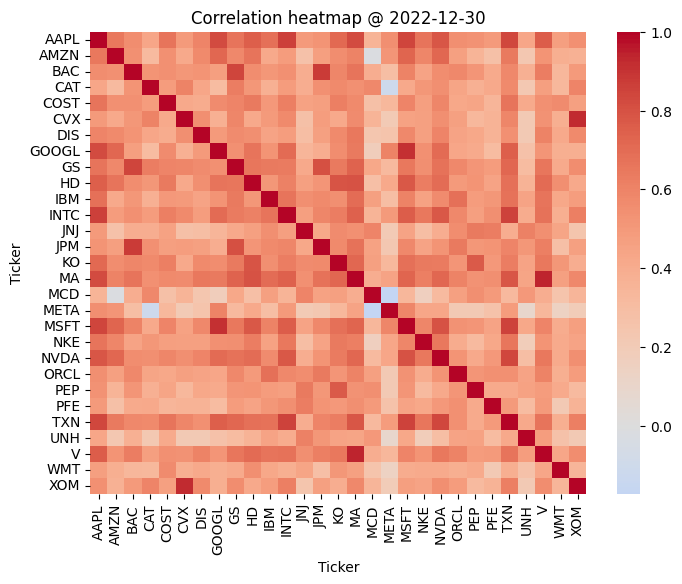

/tmp/ipython-input-3767202762.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  p_at_k_series = test_df.groupby('date').apply(


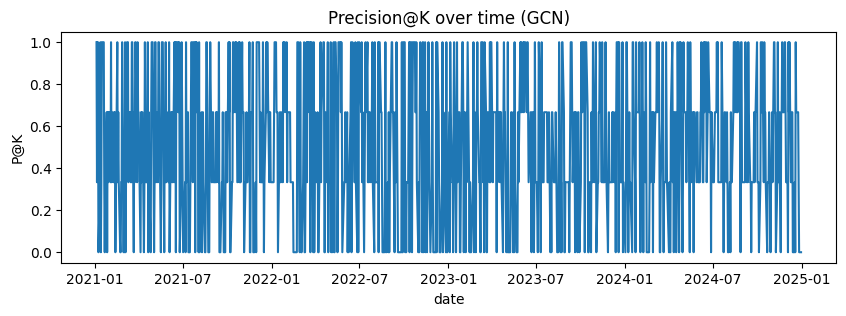

In [ ]:
# Correlation heatmap on a sample day
import seaborn as sns
sample_day = test_dates_available[len(test_dates_available)//2]
end_loc = returns_1d.index.get_loc(sample_day)
window = returns_1d.iloc[end_loc-ROLL_WINDOW+1:end_loc+1][tickers_used]
corr = window.corr().fillna(0.0)

plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title(f"Correlation heatmap @ {sample_day.date()}")
plt.show()

# ==== Consistent Precision@K over time plot ====
p_at_k_series = test_df.groupby('date').apply(
    lambda sub: precision_at_k(
        sub['score'].values,
        sub['label'].values,
        k=_resolve_k(len(sub))   # always dynamic & consistent
    )
)

p_at_k_series = p_at_k_series.sort_index()
plt.figure(figsize=(10,3))
plt.plot(p_at_k_series.index, p_at_k_series.values)
plt.title("Precision@K over time (GCN)")
plt.ylabel("P@K")
plt.xlabel("date")
plt.show()


# Quick visuals

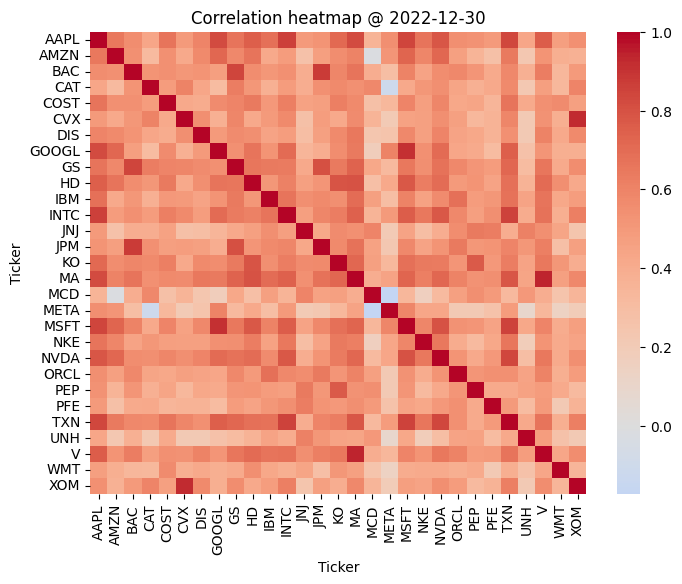

/tmp/ipython-input-4227933894.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = test_df.groupby('date').apply(


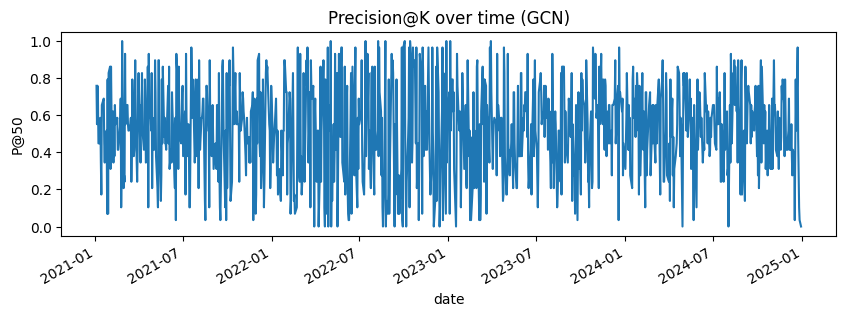

In [ ]:

# ==== Plots ====
# 1) Example correlation heatmap for a specific day
import seaborn as sns
sample_day = test_dates_available[len(test_dates_available)//2]
end_loc = returns_1d.index.get_loc(sample_day)
window = returns_1d.iloc[end_loc-ROLL_WINDOW+1:end_loc+1][tickers_used]
corr = window.corr().fillna(0.0)
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap='coolwarm', center=0); plt.title(f"Correlation heatmap @ {sample_day.date()}"); plt.show()

# 2) Test set daily p@k over time (optional)
tmp = test_df.groupby('date').apply(
    lambda sub: precision_at_k(sub['score'].values, sub['label'].values, k=min(TOP_K, len(sub)))
)
tmp.plot(figsize=(10,3)); plt.title("Precision@K over time (GCN)"); plt.ylabel(f"P@{TOP_K}"); plt.show()



---
## Notes & Conclusion
- Baselines (LogReg/XGBoost) set a tough benchmark for short-horizon stock classification.
- The GCN integrates cross-asset structure via correlation edges. Any advantage is regime‑dependent and often small.
- Random-edge and shuffled-label controls help diagnose if the GNN learns *structure* vs *noise*.
- Regime analysis shows performance sensitivity to market-wide correlation spikes (e.g., crisis periods).

**Thesis framing:** Markets are adaptive and non-stationary; graph models can capture co-movement structure but rarely produce stable outperformance versus strong tabular baselines. The value is in understanding *when* the graph helps rather than assuming it will beat the market.
